# Summary

This note contains an **explicit** routine of a neural network for MNIST digit recognizer implemented in numpy from scratch.

This is a simple demonstration mainly for pedagogical purposes, which shows the basic workflow of a machine learning algorithm using a simple feedforward neural network. The derivative at the backpropagation stage is computed explicitly through the chain rule.

* The model is a 3-layer feedforward neural network (FNN), in which the input layer has 784 units, and the 256-unit hidden layer is activated by ReLU, while the output layer is activated by softmax function to produce a discrete probability distribution for each input. 

* The loss function, model hypothesis function, and the gradient of the loss function are all implemented from ground-up in numpy in a highly vectorized fashion (no FOR loops).

* The training is through a standard gradient descent with step size adaptively changing by Root Mean Square prop (RMSprop), and there is no cross-validation set reserved nor model averaging for simplicity.


The code is vectorized and is adapted from the Softmax regression and Neural Network lectures used in [UCI Math 10](https://github.com/scaomath/UCI-Math10). 

Caveat lector: fluency in linear algebra and multivariate calculus.


#### References:
* [Stanford Deep Learning tutorial in MATLAB](http://ufldl.stanford.edu/tutorial/supervised/MultiLayerNeuralNetworks/).
* [Learning PyTorch with examples](https://pytorch.org/tutorials/beginner/pytorch_with_examples.html).
* [An overview of gradient descent optimization algorithms](http://ruder.io/optimizing-gradient-descent/).

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
%matplotlib inline

## Data input

In [2]:
import os
path = os.listdir("../input")
print(path)

['sample_submission.csv', 'train.csv', 'test.csv']


In [3]:
# Read the data
train_data = pd.read_csv('../input/train.csv')
test_data = pd.read_csv("../input/test.csv")

In [4]:
# Set up the data
y_train = train_data['label'].values
X_train = train_data.drop(columns=['label']).values/255
X_test = test_data.values/255

## Some examples of the input data
We randomly choose 10 samples from the training set and visualize it.

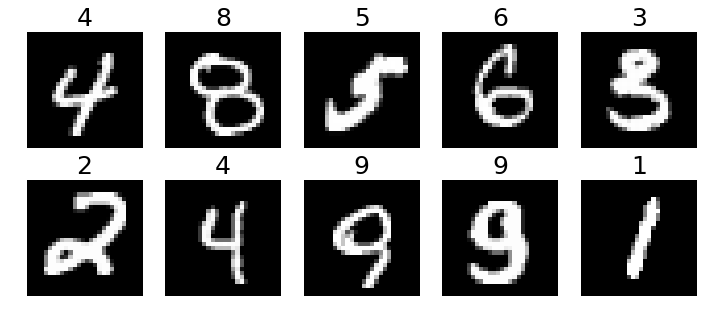

In [5]:
fig, axes = plt.subplots(2,5, figsize=(12,5))
axes = axes.flatten()
idx = np.random.randint(0,42000,size=10)
for i in range(10):
    axes[i].imshow(X_train[idx[i],:].reshape(28,28), cmap='gray')
    axes[i].axis('off') # hide the axes ticks
    axes[i].set_title(str(int(y_train[idx[i]])), color= 'black', fontsize=25)
plt.show()

# Network structures

<img src="https://raw.githubusercontent.com/scaomath/UCI-Math10/master/Lectures/neural_net_3l.png" alt="drawing" width="700"/>

The figure above is a simplication of the neural network used in this example. The circles labeled "+1" are the bias units. Layer 1 is the input layer, and Layer 3 is the output layer. The middle layer, Layer 2, is the hidden layer.

The neural network in the figure above has 2 input units (not counting the bias unit), 3 hidden units, and 1 output unit. In this actual computation below, the input layer has 784 units, the hidden layer has 256 units, and the output layers has 10 units ($K =10$ classes).

The weight matrix $W^{(0)}$ mapping input $\mathbf{x}$ from the input layer (Layer 1) to the hidden layer (Layer 2) is of shape `(784,256)` together with a `(256,)` bias. Then $\mathbf{a}$ is the activation from the hidden layer (Layer 2) can be written as:
$$
\mathbf{a} = \mathrm{ReLU}\big((W^{(0)})^{\top}\mathbf{x} + \mathbf{b}\big),
$$
where the ReLU activation function is $\mathrm{ReLU}(z) = \max(z,0)$ and can be implemented in a vectorized fashion as follows.

In [6]:
# relu activation function
# THE fastest vectorized implementation for ReLU
def relu(x):
    x[x<0]=0
    return x

## Softmax activation, prediction, and the loss function

From the hidden layer (Layer 2) to the output layer (layer 3), the weight matrix $W^{(1)}$ is of shape `(256,10)`, the form of which is as follows:
$$
W^{(1)} =
\begin{pmatrix}
| & | & | & | \\
\boldsymbol{\theta}_1 & \boldsymbol{\theta}_2 & \cdots & \boldsymbol{\theta}_K \\
| & | & | & |
\end{pmatrix},
$$
which maps the activation from Layer 2 to Layer 3 (output layer), and there is no bias because a constant can be freely added to the activation without changing the final output. 

At the last layer, a softmax activation is used, which can be written as follows combining the weights matrix $W^{(1)}$ that maps the activation $\mathbf{a}$ from the hidden layer to output layer:
$$
P\big(y = k \;| \;\mathbf{a}; W^{(1)}\big) = \sigma_k(\mathbf{a}; W^{(1)}) := \frac{\exp\big(\boldsymbol{\theta}^{\top}_k \mathbf{a} \big)}
{\sum_{j=1}^K \exp\big(\boldsymbol{\theta}^{\top}_j \mathbf{a} \big)}.
$$
$\{P\big(y = k \;| \;\mathbf{a}; W^{(1)}\big)\}_{k=1}^K$ is the probability distribution of our model, which estimates the probability of the input $\mathbf{x}$'s label $y$ is of class $k$. We denote this distribution by a vector 
$$\boldsymbol{\sigma}:= (\sigma_1,\dots, \sigma_K)^{\top}.$$
We hope that this estimate is as close as possible to the true probability: $1_{\{y=k\}}$, that is $1$ if the sample $\mathbf{x}$ is in the $k$-th class and 0 otherwise. 

Lastly, our prediction $\hat{y}$ for sample $\mathbf{x}$ can be made by choosing the class with the highest probability:
$$
\hat{y} = \operatorname{argmax}_{k=1,\dots,K}  P\big(y = k \;| \;\mathbf{a}; W^{(1)}\big). \tag{$\ast$}
$$

Denote the label of the $i$-th input as $y^{(i)}$, and then the sample-wise loss function is the cross entropy measuring the difference of the distribution of this model function above with the true one $1_{\{y^{(i)}=k\}}$: denote $W = (W^{(0)}, W^{(1)})$, $b = (\mathbf{b})$, let $\mathbf{a}^{(i)}$ be the activation for the $i$-th sample in the hidden layer (Layer 2),
$$
J_i:= J(W,b;\mathbf{x}^{(i)},y^{(i)}) := - \sum_{k=1}^{K} \left\{  1_{\left\{y^{(i)} = k\right\} }
\log P\big(y^{(i)} = k \;| \;\mathbf{a}^{(i)}; W^{(1)}\big)\right\}. \tag{1}
$$

Denote the data sample matrix $X := (\mathbf{x}^{(1)}, \dots, \mathbf{x}^{(N)})^{\top}$, its label vector as $\mathbf{y} := (y^{(1)}, \dots, y^{(N)})$, and then the final loss has an extra $L^2$-regularization term for the weight matrices (not for bias): 
$$
L(W,b; X, \mathbf{y}) := \frac{1}{N}\sum_{i=1}^{N} J_i  + \frac{\alpha}{2} \Big(\|W^{(0)}\|^2 + \|W^{(1)}\|^2\Big),
\tag{2}
$$
where $\alpha>0$ is a hyper-parameter determining the strength of the regularization, the bigger the $\alpha$ is, the smaller the magnitudes of the weights will be after training.

In [7]:
def h(X,W,b):
    '''
    Hypothesis function: simple FNN with 1 hidden layer
    Layer 1: input
    Layer 2: hidden layer, with a size implied by the arguments W[0], b
    Layer 3: output layer, with a size implied by the arguments W[1]
    '''
    # layer 1 = input layer
    a1 = X
    # layer 1 (input layer) -> layer 2 (hidden layer)
    z1 = np.matmul(X, W[0]) + b[0]
    
    # add one more layer if applicable
    
    # layer 2 activation
    a2 = relu(z1)
    # layer 2 (hidden layer) -> layer 3 (output layer)
    z2 = np.matmul(a2, W[1])
    s = np.exp(z2)
    total = np.sum(s, axis=1).reshape(-1,1)
    sigma = s/total
    # the output is a probability for each sample
    return sigma

In [8]:
def softmax(X_in,weights):
    '''
    Un-used cell for demo
    activation function for the last FC layer: softmax function 
    Output: K probabilities represent an estimate of P(y=k|X_in;weights) for k=1,...,K
    the weights has shape (n, K)
    n: the number of features X_in has
    n = X_in.shape[1]
    K: the number of classes
    K = 10
    '''
    
    s = np.exp(np.matmul(X_in,weights))
    total = np.sum(s, axis=1).reshape(-1,1)
    return s / total

In [9]:
def loss(y_pred,y_true):
    '''
    Loss function: cross entropy with an L^2 regularization
    y_true: ground truth, of shape (N, )
    y_pred: prediction made by the model, of shape (N, K) 
    N: number of samples in the batch
    K: global variable, number of classes
    '''
    global K 
    K = 10
    N = len(y_true)
    # loss_sample stores the cross entropy for each sample in X
    # convert y_true from labels to one-hot-vector encoding
    y_true_one_hot_vec = (y_true[:,np.newaxis] == np.arange(K))
    loss_sample = (np.log(y_pred) * y_true_one_hot_vec).sum(axis=1)
    # loss_sample is a dimension (N,) array
    # for the final loss, we need take the average
    return -np.mean(loss_sample)

# Backpropagation (Chain rule)

The derivative of the cross entropy $J$ in (1), for a single sample and its label $(\mathbf{x}, y)$ , with respect to the weights and the bias is computed using the following procedure:
> **Step 1**: Forward pass: computing the activations $\mathbf{a} = (a_1,\dots, a_{n_2})$ from the hidden layer (Layer 2), and $\boldsymbol{\sigma} = (\sigma_1,\dots, \sigma_K)$ from the output layer (Layer 3). 
>
> **Step 2**: Derivatives for $W^{(1)}$: recall that $W^{(1)} = (\boldsymbol{\theta}_1 ,\cdots,  \boldsymbol{\theta}_K)$ and denote 
$$\mathbf{z}^{(2)} = \big(z^{(2)}_1, \dots, z^{(2)}_K\big)  = (W^{(1)})^{\top}\mathbf{a} =
\big(\boldsymbol{\theta}^{\top}_1 \mathbf{a} ,\cdots,  \boldsymbol{\theta}^{\top}_K \mathbf{a}\big),$$ 
for the $k$-th output unit in the output layer (Layer 3), then
$$
\delta^{(2)}_k
:= \frac{\partial J}{\partial z_k^{(2)}} = \Big\{  P\big(y = k \;| \;\mathbf{a}; W^{(1)}\big)- 1_{\{ y = k\}} \Big\} = \sigma_k - 1_{\{ y = k\}}
$$
and 
$$
\frac{\partial J}{\partial \boldsymbol{\theta}_k}= \frac{\partial J}{\partial z_k^{(2)}}\frac{\partial z_k^{(2)}}{\partial \boldsymbol{\theta}_k} = \delta^{(2)}_k \mathbf{a}.
$$
>
> **Step 3**: Derivatives for $W^{(0)}$, $\mathbf{b}$: recall that $W^{(0)} = (\boldsymbol{w}_1 ,\cdots,  \boldsymbol{w}_{n_2})$, $\mathbf{b} = (b_1,\dots, b_{n_2})$, where $n_2$ is the number of units in the hidden layer (Layer 2), and denote 
$$\mathbf{z}^{(1)} = (z_1^{(1)}, \dots, z_{n_2}^{(1)})  = (W^{(0)})^{\top}\mathbf{x} + \mathbf{b} =
\big(\mathbf{w}^{\top}_1 \mathbf{x} +b_1 ,\cdots,  \mathbf{w}^{\top}_{n_2} \mathbf{x} + b_{n_2}\big),$$ 
for each node $i$ in the hidden layer (Layer $2$), $i=1,\dots, n_2$, then
$$\delta^{(1)}_i : = \frac{\partial J}{\partial z^{(1)}_i}  =
\frac{\partial J}{\partial a_i} 
\frac{\partial a_i}{\partial z^{(1)}_i}=
\frac{\partial J}{\partial \mathbf{z}^{(2)}}
\cdot\left(\frac{\partial \mathbf{z}^{(2)}}{\partial a_i} 
\frac{\partial a_i}{\partial z^{(1)}_i}\right)
\\
=\left( \sum_{k=1}^{K} \frac{\partial J}{\partial {z}^{(2)}_k}
\frac{\partial {z}^{(2)}_k}{\partial a_i}  \right) f'(z^{(1)}_i) = \left( \sum_{k=1}^{K} w_{ki} \delta^{(2)}_k \right) 1_{\{z^{(1)}_i\; > 0\}},
$$
where $1_{\{z^{(1)}_i\; > 0\}}$ is ReLU activation $f$'s (weak) derivative, and the partial derivative of the $k$-th component (before activated by the softmax) in the output layer ${z}^{(2)}_k$ with respect to the $i$-th activation $a_i$ from the hidden layer is the weight $w^{(1)}_{ki}$. Thus
>
$$
\frac{\partial J}{\partial w_{ji}}  = x_j \delta_i^{(1)} ,\;
\frac{\partial J}{\partial b_{i}} = \delta_i^{(1)}, \;\text{ and }\;
\frac{\partial J}{\partial \mathbf{w}_{i}}  = \delta_i^{(1)}\mathbf{x} ,\;
\frac{\partial J}{\partial \mathbf{b}} = \boldsymbol{\delta}^{(1)}.
$$

In [10]:
def backprop(W,b,X,y,alpha=1e-4):
    '''
    Step 1: explicit forward pass h(X;W,b)
    Step 2: backpropagation for dW and db
    '''
    K = 10
    N = X.shape[0]
    
    ### Step 1:
    # layer 1 = input layer
    a1 = X
    # layer 1 (input layer) -> layer 2 (hidden layer)
    z1 = np.matmul(X, W[0]) + b[0]
    # layer 2 activation
    a2 = relu(z1)
    
    # one more layer
    
    # layer 2 (hidden layer) -> layer 3 (output layer)
    z2 = np.matmul(a2, W[1])
    s = np.exp(z2)
    total = np.sum(s, axis=1).reshape(-1,1)
    sigma = s/total
    
    ### Step 2:
    
    # layer 2->layer 3 weights' derivative
    # delta2 is \partial L/partial z2, of shape (N,K)
    y_one_hot_vec = (y[:,np.newaxis] == np.arange(K))
    delta2 = (sigma - y_one_hot_vec)
    grad_W1 = np.matmul(a2.T, delta2)
    
    # layer 1->layer 2 weights' derivative
    # delta1 is \partial a2/partial z1
    # layer 2 activation's (weak) derivative is 1*(z1>0)
    delta1 = np.matmul(delta2, W[1].T)*(z1>0)
    grad_W0 = np.matmul(X.T, delta1)
    
    # Possible student project: extra layer of derivative
    
    # no derivative for layer 1
    
    # the alpha part is the derivative for the regularization
    # regularization = 0.5*alpha*(np.sum(W[1]**2) + np.sum(W[0]**2))
    
    
    dW = [grad_W0/N + alpha*W[0], grad_W1/N + alpha*W[1]]
    db = [np.mean(delta1, axis=0)]
    # dW[0] is W[0]'s derivative, and dW[1] is W[1]'s derivative; similar for db
    return dW, db

## Hyper-parameters and network initialization

In [11]:
eta = 5e-1
alpha = 1e-6 # regularization
gamma = 0.99 # RMSprop
eps = 1e-3 # RMSprop
num_iter = 1000 # number of iterations of gradient descent
n_H = 256 # number of neurons in the hidden layer
n = X_train.shape[1] # number of pixels in an image
K = 10

In [12]:
# initialization
np.random.seed(1127825)
W = [1e-1*np.random.randn(n, n_H), 1e-1*np.random.randn(n_H, K)]
b = [np.random.randn(n_H)]

# Gradient Descent: training of the network

In the training, we use a GD-variant of the RMSprop: for $\mathbf{w}$ which stands for the parameter vector in our model
> Choose $\mathbf{w}_0$, $\eta$, $\gamma$, $\epsilon$, and let $g_{-1} = 1$ <br><br>
>    For $k=0,1,2, \cdots, M$<br><br>
>    &nbsp;&nbsp;&nbsp;&nbsp;  $g_{k} = \gamma g_{k-1} + (1 - \gamma)\, \left|\partial_{\mathbf{w}} L (\mathbf{w}_k)\right|^2$<br><br>
>    &nbsp;&nbsp;&nbsp;&nbsp;    $\displaystyle\mathbf{w}_{k+1} =  \mathbf{w}_k -  \frac{\eta} {\sqrt{g_{k}+ \epsilon}} \partial_{\mathbf{w}} L(\mathbf{w}_k)$  

### Remark: 
The training takes a while since we use the gradient descent for all samples.

In [13]:
%%time
gW0 = gW1 = gb0 = 1

for i in range(num_iter):
    dW, db = backprop(W,b,X_train,y_train,alpha)
    
    gW0 = gamma*gW0 + (1-gamma)*np.sum(dW[0]**2)
    etaW0 = eta/np.sqrt(gW0 + eps)
    W[0] -= etaW0 * dW[0]
    
    gW1 = gamma*gW1 + (1-gamma)*np.sum(dW[1]**2)
    etaW1 = eta/np.sqrt(gW1 + eps)
    W[1] -= etaW1 * dW[1]
    
    gb0 = gamma*gb0 + (1-gamma)*np.sum(db[0]**2)
    etab0 = eta/np.sqrt(gb0 + eps)
    b[0] -= etab0 * db[0]
    
    if i % 500 == 0:
        # sanity check 1
        y_pred = h(X_train,W,b)
        print("Cross-entropy loss after", i+1, "iterations is {:.8}".format(
              loss(y_pred,y_train)))
        print("Training accuracy after", i+1, "iterations is {:.4%}".format( 
              np.mean(np.argmax(y_pred, axis=1)== y_train)))
        
        # sanity check 2
        print("gW0={:.4f} gW1={:.4f} gb0={:.4f}\netaW0={:.4f} etaW1={:.4f} etab0={:.4f}"
              .format(gW0, gW1, gb0, etaW0, etaW1, etab0))
        
        # sanity check 3
        print("|dW0|={:.5f} |dW1|={:.5f} |db0|={:.5f}"
             .format(np.linalg.norm(dW[0]), np.linalg.norm(dW[1]), np.linalg.norm(db[0])), "\n")
        
        # reset RMSprop
        gW0 = gW1 = gb0 = 1

y_pred_final = h(X_train,W,b)
print("Final cross-entropy loss is {:.8}".format(loss(y_pred_final,y_train)))
print("Final training accuracy is {:.4%}".format(np.mean(np.argmax(y_pred_final, axis=1)== y_train)))

Cross-entropy loss after 1 iterations is 7.6743264
Training accuracy after 1 iterations is 24.9262%
gW0=1.0839 gW1=1.3825 gb0=0.9923
etaW0=0.4800 etaW1=0.4251 etab0=0.5017
|dW0|=3.06418 |dW1|=6.26530 |db0|=0.48001 

Cross-entropy loss after 501 iterations is 0.13586252
Training accuracy after 501 iterations is 96.1429%
gW0=0.3495 gW1=0.1121 gb0=0.0153
etaW0=0.8446 etaW1=1.4870 etab0=3.9189
|dW0|=0.05204 |dW1|=0.02360 |db0|=0.00697 

Final cross-entropy loss is 0.065978804
Final training accuracy is 98.1000%
CPU times: user 1h 2min 50s, sys: 19min 46s, total: 1h 22min 37s
Wall time: 22min 19s


# Predictions for testing data
The prediction labels are generated by $(\ast)$.

In [14]:
# predictions
y_pred_test = np.argmax(h(X_test,W,b), axis=1)

In [15]:
# Generating submission using pandas for grading
submission = pd.DataFrame({'ImageId': range(1,len(X_test)+1) ,'Label': y_pred_test })
submission.to_csv("simplemnist_result.csv",index=False)